# Ružička: Authorship Verification in Python

In this notebook, we offer a quick tutorial as to how you could use the code in this repository. While the package is very much geared towards our own work in authorship verification, you might some of the more general functions useful. All feedback and comments are welcome. This code assumes Python 2.7+ (Python 3 has not been tested). You do not need to install the library to run the code below, but please note that there are a number of well-known third-party Python libraries, including:
+ numpy
+ scipy
+ scikit-learn
+ matplotlib
+ seaborn
+ numba

and preferably (for GPU acceleration and/or JIT-compilation):
+ theano
+ numbapro

We recommend installing Continuum's excellent [Anaconda Python framework](https://www.continuum.io/downloads), which comes bundled with most of these dependencies.


In [51]:
import logging

logging.basicConfig(level="DEBUG")

In [75]:
from ruzicka.test_metrics import nini
import numpy as np
from scipy.stats import pearsonr
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from ruzicka.Order2Verifier import Order2Verifier
from ruzicka.utilities import *
from sklearn.preprocessing import LabelEncoder
from ruzicka.score_shifting import ScoreShifter
from ruzicka.evaluation import pan_metrics
from ruzicka.BDIVerifier import BDIVerifier
import pandas as pd

## Walk through

By default, we assume that your data sets are stored in a directory the format on the PAN 2014 track on authorship attribution: a directory should minimally include one folder per verification problem (an `unknown.txt` and at least one `known01.txt`) and a `truth.txt`. E.g. for the corpus of Dutch essays (`../data/2014/du_essays/train`), `truth.txt` contains has a tab-separated line with the ground truth for each problem:

```
DE001 Y
DE002 Y
DE003 N
DE004 N
DE005 N
DE006 N
DE007 N
DE008 Y
...
```

To inspect the problems:

In [3]:
! ls ../data/2014/du_essays/train

DE001         DE021         DE041         DE061         DE081
DE002         DE022         DE042         DE062         DE082
DE003         DE023         DE043         DE063         DE083
DE004         DE024         DE044         DE064         DE084
DE005         DE025         DE045         DE065         DE085
DE006         DE026         DE046         DE066         DE086
DE007         DE027         DE047         DE067         DE087
DE008         DE028         DE048         DE068         DE088
DE009         DE029         DE049         DE069         DE089
DE010         DE030         DE050         DE070         DE090
DE011         DE031         DE051         DE071         DE091
DE012         DE032         DE052         DE072         DE092
DE013         DE033         DE053         DE073         DE093
DE014         DE034         DE054         DE074         DE094
DE015         DE035         DE055         DE075         DE095
DE016         DE036         DE056         DE076         DE096
DE017   

Let us now load the set of development problems for the Dutch essays:

In [4]:

D = "../data/2014/du_essays/"
dev_train_data, dev_test_data = load_pan_dataset(D + "train")

This functions loads all documents and splits the development data into a development part (the known documents) and a testing part (the unknown documents). We can unpack these as follows:

In [5]:
dev_train_labels, dev_train_documents = zip(*dev_train_data)
dev_test_labels, dev_test_documents = zip(*dev_test_data)

Let us have a look at the actual test texts:

In [6]:
for doc in dev_test_documents[:10]:
    print("+ ", doc[:70])

+  ﻿Dankzij het internet zijn we een grote bron aan informatie rijker . A
+  ﻿Het is dus begrijpelijk dat de commerciële zenders meer reclame moete
+  ﻿" Hey , vuile nicht ! Hangt er nog stront aan je lul ? " . Dergelijke
+  ﻿Gelijkheid tussen man en vrouw is iets dat ons al eeuwen in de ban ho
+  ﻿Gisteren was er opnieuw een protest tegen homofilie in de grootstad P
+  ﻿Voetbal is vandaag de dag zonder twijfel de populairste sport in Belg
+  ﻿Door de ongekende groei van nieuwsbronnen en de opkomst van het inter
+  ﻿Woordenboekgebruik uit interesse De categorie woordenboekgebruikers d
+  ﻿Ze bouwden een tegencultuur op die alles verwierp waar hun ouders alt
+  ﻿Als we hier in België op straat rondlopen , merken we dat er zeer vee


For each of these documents we need to decide whether or not they were in fact written by the target authors proposed:

In [7]:
for doc in dev_test_labels[:10]:
    print("+ ", doc[:70])

+  DE001
+  DE002
+  DE003
+  DE004
+  DE005
+  DE006
+  DE007
+  DE008
+  DE009
+  DE010


The first and crucial step is to vectorize the documents using a vector space model. Below, we use generic example, using the 10,000 most common word unigrams and a plain *tf* model:

In [8]:
# from ruzicka.vectorization import Vectorizer
vectorizer = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(2, 4),
        max_features=5000,
    ),
    StandardScaler(with_mean=False),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
)
# vectorizer = Vectorizer(mfi=10000, vector_space="tf", ngram_type="word", ngram_size=1)

dev_train_X = vectorizer.fit_transform(dev_train_documents)
dev_test_X = vectorizer.transform(dev_test_documents)

In [55]:
vectorizer.__class__

sklearn.pipeline.Pipeline

Note that we use `sklearn` conventions here: we fit the vectorizer only on the vocabulary of the known documents and apply it it later to the unknown documents (since in real life too, we will not necessarily know the known documents in advance). This gives us two compatible corpus matrices:

We now encode the author labels in the development problem sets as integers, using sklearn's convenient `LabelEncoder`:

In [9]:

label_encoder = LabelEncoder()
label_encoder.fit(dev_train_labels + dev_test_labels)
dev_train_y = np.array(label_encoder.transform(dev_train_labels))
dev_test_y = np.array(label_encoder.transform(dev_test_labels))
print(dev_test_y)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


We now construct and fit an 'O2' verifier: this extrinsic verification technique is based on the General Imposters framework. We apply it with the minmax metric and a profile base, meaning that the known documents for each author will be represented as a mean centroid:

In [21]:

dev_verifier = BDIVerifier(metric="cosine", nb_bootstrap_iter=500, rnd_prop=0.35)
dev_verifier.fit(dev_train_X, dev_train_y)

01/11/2024 11:59:05 [ruzicka:INFO] Fitting on 172 documents...


In [ ]:
# import time

# CPU_METRICS = ["manhattan", "euclidean", "minmax", "cng", "cosine", "nini"]
# for d in CPU_METRICS[0:]:
#     print(f"Starting {d}")
#     dev_verifier = BDIVerifier(metric=d, nb_bootstrap_iter=100, rnd_prop=0.35)
#     dev_verifier.fit(dev_train_X, dev_train_y)
#     t = time.time()
#     dev_test_scores = dev_verifier.predict_proba(test_X=dev_test_X, test_y=dev_test_y)
#     print(f"Time: {time.time()-t}")

We can now obtain the probability which this O1 verifier would assign to each combination of an unknown document and the target author suggested in the problem:

In [36]:
dev_test_scores = dev_verifier.predict_proba(test_X=dev_test_X, test_y=dev_test_y)

This gives us as an array of probability scores for each problem, corresponding to the number of iterations in which the target's author's profile was closer to the anonymous document than to one of the imposters:

In [23]:
print(dev_test_scores)

[0.96  0.996 0.01  0.    0.502 0.418 0.    1.    1.    1.    1.    0.97
 1.    1.    0.258 0.956 0.934 0.    0.012 1.    0.008 0.    1.    0.994
 0.008 1.    0.02  0.982 0.05  0.016 0.    0.    0.818 0.    0.    0.872
 0.01  0.    0.69  0.024 0.988 0.994 0.    1.    1.    0.01  0.214 0.
 0.128 0.826 0.    0.85  0.01  0.986 0.964 0.    0.49  1.    0.    1.
 1.    0.998 1.    0.588 1.    1.    1.    0.904 1.    1.    0.054 0.
 0.15  0.998 0.138 0.004 0.694 0.    1.    0.004 0.998 0.938 0.    0.
 1.    0.016 1.    1.    0.012 0.    0.    0.998 0.    0.004 1.    0.998]


Let us now load the ground truth to check how well we did:

In [15]:
dev_gt_scores = load_ground_truth(
    filepath=os.sep.join((D, "train", "truth.txt")), labels=dev_test_labels
)
print(dev_gt_scores)

[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]


There is one final step needed: the PAN evaluation measures allow systems to leave a number of difficult problems unanswered, by setting the probability exactly at 0.5. To account for this strict threshold, we fit a score shifter, which will attempt to rectify mid-range score to 0.5. We can tune these parameters as follows:

In [24]:

shifter = ScoreShifter(min_spread=0.5)
shifter.fit(predicted_scores=dev_test_scores, ground_truth_scores=dev_gt_scores)
dev_test_scores = shifter.transform(dev_test_scores)

01/11/2024 11:59:33 [ruzicka:INFO] p1 for optimal combo: 0.200
01/11/2024 11:59:33 [ruzicka:INFO] p2 for optimal combo: 0.704
01/11/2024 11:59:33 [ruzicka:INFO] AUC for optimal combo: 95.68%
01/11/2024 11:59:33 [ruzicka:INFO] c@1 for optimal combo: 94.79%


As you can see, this shifter optimizes 2 parameters using a grid search: all values in between *p1* and *p2* will be rectified to 0.5:

In [37]:
print(dev_test_scores)

[0.5, 0.023599976400023596, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999994160005841, 0.9999994160005841, 0.9976634183365818, 0.9999994160005841, 0.5, 0.9999994160005841, 0.9999994160005841, 0.0, 0.9486074673925327, 0.8504955655044346, 0.0, 0.0, 0.9999994160005841, 0.0, 0.0, 0.9999994160005841, 0.9906554253445747, 0.0, 0.9999994160005841, 0.0, 0.7734076425923575, 0.0, 0.0, 0.0, 0.0, 0.9602874557125445, 0.0, 0.0, 0.9112315047684953, 0.0, 0.0, 0.0, 0.0, 0.5, 0.9661274498725503, 0.0, 0.9999994160005841, 0.9999994160005841, 0.0, 0.0, 0.0, 0.0, 0.005599994400005595, 0.0, 0.012799987200012786, 0.0, 0.9999994160005841, 0.7500476659523341, 0.0, 0.0007999992000007832, 0.9964954195045808, 0.0, 0.9999994160005841, 0.9999994160005841, 0.998831417168583, 0.9999994160005841, 0.0, 0.9999994160005841, 0.9999994160005841, 0.9976634183365818, 0.5, 0.98598343001657, 0.998831417168583, 0.0, 0.0, 0.0, 0.9999994160005841, 0.0, 0.0, 0.00039999960000037735, 0.0, 0.9999994160005841, 0.0, 0.9999994160005841, 0.8715195444804

<AxesSubplot:ylabel='Density'>

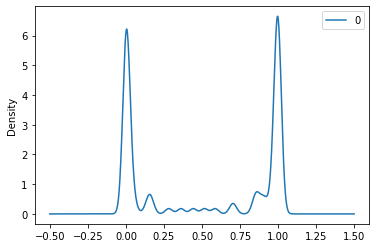

In [40]:
import pandas as pd

pd.DataFrame(dev_test_scores).plot.kde(bw_method=0.05)

We can later apply this optimized score shifter to the test problems. Now the main question: how well would our O2 verifier perform on the development problems, given the optimal *p1* and *p2* found? We answer this question using the three evaluation measures used in the PAN competition.

In [25]:

shifter = ScoreShifter().manual_fit(0.25, 0.75)

dev_acc_score, dev_auc_score, dev_c_at_1_score = pan_metrics(
    prediction_scores=dev_test_scores, ground_truth_scores=dev_gt_scores
)
print("Accuracy: ", dev_acc_score)
print("AUC: ", dev_auc_score)
print("c@1: ", dev_c_at_1_score)
print("AUC x c@1: ", dev_auc_score * dev_c_at_1_score)

Accuracy:  0.9270833333333334
AUC:  0.9568142361111112
c@1:  0.9479166666666666
AUC x c@1:  0.9069801613136574


Our score shifting approach clearly pays off, since we are able to leave difficult problems unswered, yielding to a higher c@1 than pure accuracy. We can now proceed to the test problems. The following code block runs entire parallel to the approach above: only the score shifter isn't retrained again:

In [34]:
train_data, test_data = load_pan_dataset(D + "test")
train_labels, train_documents = zip(*train_data)
test_labels, test_documents = zip(*test_data)

# # vectorize:
# vectorizer = Vectorizer(mfi=10000, vector_space="tf", ngram_type="word", ngram_size=1)
train_X = vectorizer.fit_transform(train_documents)
test_X = vectorizer.transform(test_documents)

# encode author labels:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels + test_labels)
train_y = np.array(label_encoder.transform(train_labels), dtype="int")
test_y = np.array(label_encoder.transform(test_labels), dtype="int")

# fit and predict a verifier on the test data:
test_verifier = BDIVerifier(metric="cosine", nb_bootstrap_iter=500, rnd_prop=0.33)
test_verifier.fit(train_X, train_y)
test_scores = test_verifier.predict_proba(test_X=test_X, test_y=np.array(test_y))

# load the ground truth:
test_gt_scores = load_ground_truth(
    filepath=os.sep.join((D, "test", "truth.txt")), labels=test_labels
)

# apply the optimzed score shifter:
# shifter = ScoreShifter().manual_fit(0.055, 0.945)
shifter = ScoreShifter().manual_fit(0.25, 0.75)

test_scores = shifter.transform(test_scores)

test_acc_score, test_auc_score, test_c_at_1_score = pan_metrics(
    prediction_scores=test_scores, ground_truth_scores=test_gt_scores
)

print("Accuracy: ", test_acc_score)
print("AUC: ", test_auc_score)
print("c@1: ", test_c_at_1_score)
print("AUC x c@1: ", test_auc_score * test_c_at_1_score)

01/11/2024 12:03:03 [ruzicka:INFO] Fitting on 191 documents...


Accuracy:  0.90625
AUC:  0.9637586805555555
c@1:  0.9461805555555555
AUC x c@1:  0.9118897237895446


In [41]:
train_data, test_data = load_pan_dataset(D + "test")
train_labels, train_documents = zip(*train_data)
test_labels, test_documents = zip(*test_data)

# # vectorize:
# vectorizer = Vectorizer(mfi=10000, vector_space="tf", ngram_type="word", ngram_size=1)
train_X = vectorizer.fit_transform(train_documents)
test_X = vectorizer.transform(test_documents)

# encode author labels:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels + test_labels)
train_y = np.array(label_encoder.transform(train_labels), dtype="int")
test_y = np.array(label_encoder.transform(test_labels), dtype="int")

# fit and predict a verifier on the test data:
test_verifier = Order2Verifier(
    metric="minmax", base="instance", rank=True, nb_bootstrap_iter=500, rnd_prop=0.5
)
test_verifier.fit(train_X, train_y)
test_scores = test_verifier.predict_proba(
    test_X=test_X, test_y=np.array(test_y), nb_imposters=30
)

# load the ground truth:
test_gt_scores = load_ground_truth(
    filepath=os.sep.join((D, "test", "truth.txt")), labels=test_labels
)

# apply the optimzed score shifter:
# test_scores = shifter.transform(test_scores)

test_acc_score, test_auc_score, test_c_at_1_score = pan_metrics(
    prediction_scores=test_scores, ground_truth_scores=test_gt_scores
)

print("Accuracy: ", test_acc_score)
print("AUC: ", test_auc_score)
print("c@1: ", test_c_at_1_score)
print("AUC x c@1: ", test_auc_score * test_c_at_1_score)

01/11/2024 12:48:45 [ruzicka:INFO] Fitting on 191 documents in instance mode...
01/11/2024 12:48:45 [ruzicka:INFO] Predicting on 96 documents


Accuracy:  0.9166666666666666
AUC:  0.9670138888888888
c@1:  0.9166666666666666
AUC x c@1:  0.886429398148148


In [2]:
prefix = "../data/2014/"
corpora = [
    "du_essays",
    "du_reviews",
    "en_essays",
    "en_novels",
    "gr_articles",
    "sp_articles",
]

In [3]:
from typing import Union

In [103]:
def fit_shifter(
    corpus: str, vectorizer: Pipeline, verifier: Union[BDIVerifier, Order2Verifier]
) -> ScoreShifter:
    logger.info("Fitting shifter")
    train_data, test_data = load_pan_dataset(os.path.join(prefix, corpus, "train"))
    train_labels, train_documents = zip(*train_data)
    test_labels, test_documents = zip(*test_data)
    train_X = vectorizer.fit_transform(train_documents)
    test_X = vectorizer.transform(test_documents)
    label_encoder = LabelEncoder()
    label_encoder.fit(train_labels + test_labels)
    train_y = np.array(label_encoder.transform(train_labels), dtype="int")
    test_y = np.array(label_encoder.transform(test_labels), dtype="int")
    verifier.fit(train_X, train_y)
    test_scores = verifier.predict_proba(
        test_X=test_X, test_y=np.array(test_y), nb_imposters=30
    )
    gt_scores = load_ground_truth(
        filepath=os.path.join(prefix, corpus, "train", "truth.txt"), labels=test_labels
    )
    shifter = ScoreShifter()
    shifter.fit(predicted_scores=test_scores, ground_truth_scores=gt_scores)
    return shifter

In [88]:
o2v = Order2Verifier(
    metric="minmax", base="instance", rank=True, nb_bootstrap_iter=500, rnd_prop=0.5
)
vectorizer = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(3, 5),
        max_features=10000,
    ),
    StandardScaler(with_mean=False),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
)

bdiv = BDIVerifier(metric="cosine", nb_bootstrap_iter=1000, rnd_prop=0.33)

In [38]:
logger = logging.getLogger("ruzicka")

In [107]:
def evaluate(corpus, vectorizer, verifier, shifter):
    logger.info("Loading evaluation corpus")
    train_data, test_data = load_pan_dataset(os.path.join(prefix, corpus, "test"))
    train_labels, train_documents = zip(*train_data)
    test_labels, test_documents = zip(*test_data)
    train_X = vectorizer.fit_transform(train_documents)
    test_X = vectorizer.transform(test_documents)
    label_encoder = LabelEncoder()
    label_encoder.fit(train_labels + test_labels)
    train_y = np.array(label_encoder.transform(train_labels), dtype="int")
    test_y = np.array(label_encoder.transform(test_labels), dtype="int")
    verifier.fit(train_X, train_y)
    test_scores = verifier.predict_proba(
        test_X=test_X, test_y=np.array(test_y), nb_imposters=30
    )
    gt_scores = load_ground_truth(
        filepath=os.path.join(prefix, corpus, "test", "truth.txt"), labels=test_labels
    )
    unanswered = (
        (shifter.optimal_p1 < test_scores) & (test_scores < shifter.optimal_p2)
    ).sum()
    high_conf = ((0.055 > test_scores) | (test_scores > 0.945)).sum()
    test_scores = np.array(shifter.transform(test_scores))
    badness = np.abs(test_scores - gt_scores).sum()
    fps = ((test_scores - gt_scores) > shifter.optimal_p2).sum()
    acc_score, auc_score, c_at_1_score = pan_metrics(
        prediction_scores=test_scores, ground_truth_scores=gt_scores
    )

    logger.info(f"Unanswered: {unanswered}")
    logger.info(f"High Confidence: {high_conf}")
    logger.info(f"False Positives: {fps}")
    logger.info(f"Badness: {badness:.3f}")
    logger.info(f"Accuracy: {acc_score:.3f}")
    logger.info(f"AUC: {auc_score:.3f}")
    logger.info(f"c@1: {c_at_1_score:.3f}")
    logger.info(f"AUC x c@1: {auc_score * c_at_1_score:.3f}")
    return {
        "test_size": len(test_scores),
        "unanswed": unanswered,
        "high_conf": high_conf,
        "badness": badness,
        "false_positives": fps,
        "accuracy": acc_score,
        "auc": auc_score,
        "c@1": c_at_1_score,
        "final_score": auc_score * c_at_1_score,
    }

In [108]:
spanish = evaluate(
    "sp_articles", vectorizer, bdiv, fit_shifter("sp_articles", vectorizer, bdiv)
)

01/15/2024 01:11:44 [ruzicka:INFO] Fitting shifter
01/15/2024 01:11:49 [ruzicka:INFO] Fitting on 500 documents...
01/15/2024 01:11:49 [ruzicka:INFO] Predicting on 100 documents
01/15/2024 01:12:40 [ruzicka:INFO] p1 for optimal combo: 0.242
01/15/2024 01:12:40 [ruzicka:INFO] p2 for optimal combo: 0.380
01/15/2024 01:12:40 [ruzicka:INFO] AUC for optimal combo: 83.98%
01/15/2024 01:12:40 [ruzicka:INFO] c@1 for optimal combo: 80.85%
01/15/2024 01:12:40 [ruzicka:INFO] Loading evaluation corpus
01/15/2024 01:12:45 [ruzicka:INFO] Fitting on 500 documents...
01/15/2024 01:12:45 [ruzicka:INFO] Predicting on 100 documents
01/15/2024 01:13:33 [ruzicka:INFO] Unanswered: 5
01/15/2024 01:13:33 [ruzicka:INFO] High Confidence: 50
01/15/2024 01:13:33 [ruzicka:INFO] False Positives: 14
01/15/2024 01:13:33 [ruzicka:INFO] Badness: 18.573
01/15/2024 01:13:33 [ruzicka:INFO] Accuracy: 0.820
01/15/2024 01:13:33 [ruzicka:INFO] AUC: 0.927
01/15/2024 01:13:33 [ruzicka:INFO] c@1: 0.851
01/15/2024 01:13:33 [ruzick

In [109]:
pd.DataFrame([spanish])

,test_size,unanswed,high_conf,badness,false_positives,accuracy,auc,c@1,final_score
0,100,5,50,18.57293,14,0.82,0.9266,0.8505,0.788073


In [104]:
evaluate("sp_articles", vectorizer, o2v, fit_shifter("sp_articles", vectorizer, o2v))

01/15/2024 12:51:49 [ruzicka:INFO] Fitting shifter
01/15/2024 12:51:54 [ruzicka:INFO] Fitting on 500 documents in instance mode...
01/15/2024 12:51:54 [ruzicka:INFO] Predicting on 100 documents
01/15/2024 12:52:31 [ruzicka:INFO] p1 for optimal combo: 0.440
01/15/2024 12:52:31 [ruzicka:INFO] p2 for optimal combo: 0.644
01/15/2024 12:52:31 [ruzicka:INFO] AUC for optimal combo: 81.90%
01/15/2024 12:52:31 [ruzicka:INFO] c@1 for optimal combo: 79.80%
01/15/2024 12:52:31 [ruzicka:INFO] Loading evaluation corpus
01/15/2024 12:52:35 [ruzicka:INFO] Fitting on 500 documents in instance mode...
01/15/2024 12:52:35 [ruzicka:INFO] Predicting on 100 documents
01/15/2024 12:53:09 [ruzicka:INFO] Unanswered: 11
01/15/2024 12:53:09 [ruzicka:INFO] High Confidence: 25
01/15/2024 12:53:09 [ruzicka:INFO] Badness: 20.809
01/15/2024 12:53:09 [ruzicka:INFO] Accuracy: 0.760
01/15/2024 12:53:09 [ruzicka:INFO] AUC: 0.936
01/15/2024 12:53:09 [ruzicka:INFO] c@1: 0.844
01/15/2024 12:53:09 [ruzicka:INFO] AUC x c@1: 0

{'test_size': 100,
 'unanswed': 11,
 'high_conf': 25,
 'badness': 20.80915657086988,
 'accuracy': 0.76,
 'auc': 0.9356,
 'c@1': 0.8436,
 'final_score': 0.78927216}

In [89]:
results = []
for corpus in corpora:
    classifier = "BDI Cosine Manual"
    # this = evaluate(corpus, vectorizer, bdiv, fit_shifter(corpus, vectorizer, bdiv))
    this = evaluate(corpus, vectorizer, bdiv, ScoreShifter().manual_fit(0.25, 0.75))
    this["classifier"] = classifier
    this["corpus"] = corpus
    results.append(this)

01/14/2024 10:41:45 [ruzicka:INFO] Loading evaluation corpus
01/14/2024 10:41:46 [ruzicka:INFO] Fitting on 191 documents...
01/14/2024 10:41:46 [ruzicka:INFO] Predicting on 96 documents
01/14/2024 10:42:28 [ruzicka:INFO] Unanswered: 11
01/14/2024 10:42:28 [ruzicka:INFO] High Confidence: 72
01/14/2024 10:42:28 [ruzicka:INFO] Badness: 11.004
01/14/2024 10:42:28 [ruzicka:INFO] Accuracy: 0.885
01/14/2024 10:42:28 [ruzicka:INFO] AUC: 0.948
01/14/2024 10:42:28 [ruzicka:INFO] c@1: 0.929
01/14/2024 10:42:28 [ruzicka:INFO] AUC x c@1: 0.880
01/14/2024 10:42:28 [ruzicka:INFO] Loading evaluation corpus
01/14/2024 10:42:28 [ruzicka:INFO] Fitting on 50 documents...
01/14/2024 10:42:28 [ruzicka:INFO] Predicting on 50 documents
01/14/2024 10:42:49 [ruzicka:INFO] Unanswered: 6
01/14/2024 10:42:49 [ruzicka:INFO] High Confidence: 38
01/14/2024 10:42:49 [ruzicka:INFO] Badness: 21.096
01/14/2024 10:42:49 [ruzicka:INFO] Accuracy: 0.600
01/14/2024 10:42:49 [ruzicka:INFO] AUC: 0.623
01/14/2024 10:42:49 [ruzic

In [87]:
bdi_mm_man = pd.DataFrame(results)
bdi_mm_man

,test_size,unanswed,high_conf,badness,accuracy,auc,c@1,final_score,classifier,corpus
0,96,11,72,11.750009,0.864583,0.955512,0.917209,0.876405,BDI Minmax Manual,du_essays
1,50,4,34,21.035501,0.580000,0.675200,0.583200,0.393777,BDI Minmax Manual,du_reviews
2,200,16,162,90.635387,0.560000,0.633100,0.545400,0.345293,BDI Minmax Manual,en_essays
3,200,18,161,84.979827,0.600000,0.638550,0.577700,0.368890,BDI Minmax Manual,en_novels
4,100,22,62,31.071002,0.780000,0.842200,0.707600,0.595941,BDI Minmax Manual,gr_articles
5,100,23,53,17.421257,0.850000,0.920800,0.885600,0.815460,BDI Minmax Manual,sp_articles


In [90]:
bdi_cs_man = pd.DataFrame(results)
bdi_cs_man

,test_size,unanswed,high_conf,badness,accuracy,auc,c@1,final_score,classifier,corpus
0,96,11,72,11.003509,0.885417,0.94770,0.928819,0.880242,BDI Cosine Manual,du_essays
1,50,6,38,21.096001,0.600000,0.62320,0.582400,0.362952,BDI Cosine Manual,du_reviews
2,200,12,166,91.792544,0.555000,0.60495,0.540600,0.327036,BDI Cosine Manual,en_essays
3,200,19,157,84.524188,0.605000,0.63605,0.580350,0.369132,BDI Cosine Manual,en_novels
4,100,21,59,29.741378,0.780000,0.86080,0.726000,0.624941,BDI Cosine Manual,gr_articles
5,100,24,50,18.045257,0.830000,0.91360,0.880400,0.804333,BDI Cosine Manual,sp_articles


In [91]:
bdi_cs_man.final_score.mean()

0.5614392287488748

In [92]:
bdi_mm_man.final_score.mean()

0.5659609089277805

In [102]:
results = []
for corpus in corpora:
    classifier = "Kestemont Minmax Manual"
    this = evaluate(corpus, vectorizer, bdiv, fit_shifter(corpus, vectorizer, bdiv))
    this["classifier"] = classifier
    this["corpus"] = corpus
    results.append(this)

TypeError: fit_shifter() missing 2 required positional arguments: 'verifier' and 'shifter'

In [96]:
vectorizer_35 = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(3, 5),
        max_features=10000,
    ),
    StandardScaler(with_mean=False),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
)

vectorizer_24 = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(2, 4),
        max_features=10000,
    ),
    StandardScaler(with_mean=False),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
)

vecs = [
    ("3,4,5-grams Standard Scaler", vectorizer_35),
    ("2,3,4-grams Standard Scaler", vectorizer_24),
]

In [98]:
o2v_mm = Order2Verifier(
    metric="minmax", base="instance", rank=True, nb_bootstrap_iter=500, rnd_prop=0.5
)
o2v_cs = Order2Verifier(
    metric="cosine", base="instance", rank=True, nb_bootstrap_iter=500, rnd_prop=0.5
)
bdi_mm = BDIVerifier(metric="minmax", nb_bootstrap_iter=500, rnd_prop=0.33)
bdi_cs = BDIVerifier(metric="cosine", nb_bootstrap_iter=500, rnd_prop=0.33)

classifs = [
    ("Kestemont GI, Minmax", o2v_mm),
    ("Kestemont GI, Cosine", o2v_cs),
    ("BDI, Minmax", bdi_mm),
    ("BDI, Cosine", bdi_cs),
]

In [110]:
results = []
for corpus in corpora:
    for classif_name, classif in classifs:
        for vec_name, vec in vecs:
            manual = evaluate(
                corpus, vec, classif, ScoreShifter().manual_fit(0.11, 0.89)
            )
            manual["classifier"] = f"{classif_name} + {vec_name} + manual shifter"
            manual["corpus"] = corpus
            results.append(manual)
            fitted = evaluate(
                corpus,
                vec,
                classif,
                fit_shifter(corpus, vec, classif),
            )
            fitted["classifier"] = f"{classif_name} + {vec_name} + fitted shifter"
            fitted["corpus"] = corpus
            results.append(fitted)

01/15/2024 01:14:38 [ruzicka:INFO] Loading evaluation corpus
01/15/2024 01:14:39 [ruzicka:INFO] Fitting on 191 documents in instance mode...
01/15/2024 01:14:39 [ruzicka:INFO] Predicting on 96 documents
01/15/2024 01:15:02 [ruzicka:INFO] Unanswered: 28
01/15/2024 01:15:02 [ruzicka:INFO] High Confidence: 52
01/15/2024 01:15:02 [ruzicka:INFO] False Positives: 2
01/15/2024 01:15:02 [ruzicka:INFO] Badness: 16.117
01/15/2024 01:15:02 [ruzicka:INFO] Accuracy: 0.771
01/15/2024 01:15:02 [ruzicka:INFO] AUC: 0.940
01/15/2024 01:15:02 [ruzicka:INFO] c@1: 0.888
01/15/2024 01:15:02 [ruzicka:INFO] AUC x c@1: 0.835
01/15/2024 01:15:02 [ruzicka:INFO] Fitting shifter
01/15/2024 01:15:03 [ruzicka:INFO] Fitting on 172 documents in instance mode...
01/15/2024 01:15:03 [ruzicka:INFO] Predicting on 96 documents
01/15/2024 01:15:29 [ruzicka:INFO] p1 for optimal combo: 0.224
01/15/2024 01:15:29 [ruzicka:INFO] p2 for optimal combo: 0.686
01/15/2024 01:15:29 [ruzicka:INFO] AUC for optimal combo: 94.14%
01/15/20

In [112]:
df = pd.DataFrame(results)

In [117]:
df.loc[df.groupby("corpus")["final_score"].idxmax()]

,test_size,unanswed,high_conf,badness,false_positives,accuracy,auc,c@1,final_score,classifier,corpus
3,96,11,52,10.589767,4,0.875,0.967231,0.94043,0.909613,"Kestemont GI, Minmax + 2,3,4-grams Standard Sc...",du_essays
23,50,0,8,19.933620,3,0.640,0.753600,0.64000,0.482304,"Kestemont GI, Cosine + 2,3,4-grams Standard Sc...",du_reviews
43,200,4,161,88.839098,5,0.575,0.632700,0.57120,0.361398,"BDI, Minmax + 2,3,4-grams Standard Scaler + fi...",en_essays
53,200,13,83,79.582436,13,0.630,0.673500,0.62835,0.423194,"Kestemont GI, Cosine + 3,4,5-grams Standard Sc...",en_novels
69,100,16,21,24.832939,7,0.760,0.851000,0.80040,0.681140,"Kestemont GI, Cosine + 3,4,5-grams Standard Sc...",gr_articles
89,100,4,54,17.696237,13,0.830,0.922600,0.86320,0.796388,"BDI, Minmax + 3,4,5-grams Standard Scaler + fi...",sp_articles


In [118]:
df

,test_size,unanswed,high_conf,badness,false_positives,accuracy,auc,c@1,final_score,classifier,corpus
0,96,28,52,16.116702,2,0.770833,0.940321,0.888021,0.835025,"Kestemont GI, Minmax + 3,4,5-grams Standard Sc...",du_essays
1,96,14,53,12.570496,4,0.822917,0.959635,0.919054,0.881957,"Kestemont GI, Minmax + 3,4,5-grams Standard Sc...",du_essays
2,96,28,51,16.151007,2,0.739583,0.943359,0.888021,0.837723,"Kestemont GI, Minmax + 2,3,4-grams Standard Sc...",du_essays
3,96,11,52,10.589767,4,0.875000,0.967231,0.940430,0.909613,"Kestemont GI, Minmax + 2,3,4-grams Standard Sc...",du_essays
4,96,32,49,18.113540,2,0.739583,0.922526,0.861111,0.794397,"Kestemont GI, Cosine + 3,4,5-grams Standard Sc...",du_essays
...,...,...,...,...,...,...,...,...,...,...,...
91,100,1,52,18.196483,15,0.820000,0.938400,0.828200,0.777183,"BDI, Minmax + 2,3,4-grams Standard Scaler + fi...",sp_articles
92,100,39,50,24.626723,1,0.760000,0.865800,0.778400,0.673939,"BDI, Cosine + 3,4,5-grams Standard Scaler + ma...",sp_articles
93,100,9,50,19.401279,16,0.800000,0.920200,0.850200,0.782354,"BDI, Cosine + 3,4,5-grams Standard Scaler + fi...",sp_articles
94,100,41,52,25.584263,1,0.750000,0.860200,0.761400,0.654956,"BDI, Cosine + 2,3,4-grams Standard Scaler + ma...",sp_articles


In [120]:
df[["classif", "vec", "shifter"]] = df["classifier"].str.split("+", expand=True)

In [125]:
df = df.drop("classifier", axis=1)

In [126]:
df

,test_size,unanswed,high_conf,badness,false_positives,accuracy,auc,c@1,final_score,corpus,classif,vec,shifter
0,96,28,52,16.116702,2,0.770833,0.940321,0.888021,0.835025,du_essays,"Kestemont GI, Minmax","3,4,5-grams Standard Scaler",manual shifter
1,96,14,53,12.570496,4,0.822917,0.959635,0.919054,0.881957,du_essays,"Kestemont GI, Minmax","3,4,5-grams Standard Scaler",fitted shifter
2,96,28,51,16.151007,2,0.739583,0.943359,0.888021,0.837723,du_essays,"Kestemont GI, Minmax","2,3,4-grams Standard Scaler",manual shifter
3,96,11,52,10.589767,4,0.875000,0.967231,0.940430,0.909613,du_essays,"Kestemont GI, Minmax","2,3,4-grams Standard Scaler",fitted shifter
4,96,32,49,18.113540,2,0.739583,0.922526,0.861111,0.794397,du_essays,"Kestemont GI, Cosine","3,4,5-grams Standard Scaler",manual shifter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,100,1,52,18.196483,15,0.820000,0.938400,0.828200,0.777183,sp_articles,"BDI, Minmax","2,3,4-grams Standard Scaler",fitted shifter
92,100,39,50,24.626723,1,0.760000,0.865800,0.778400,0.673939,sp_articles,"BDI, Cosine","3,4,5-grams Standard Scaler",manual shifter
93,100,9,50,19.401279,16,0.800000,0.920200,0.850200,0.782354,sp_articles,"BDI, Cosine","3,4,5-grams Standard Scaler",fitted shifter
94,100,41,52,25.584263,1,0.750000,0.860200,0.761400,0.654956,sp_articles,"BDI, Cosine","2,3,4-grams Standard Scaler",manual shifter


In [135]:
df[df.classif.str.contains("BDI")].sort_values(
    ["corpus", "final_score"], ascending=False
)

,test_size,unanswed,high_conf,badness,false_positives,accuracy,auc,c@1,final_score,corpus,classif,vec,shifter
89,100,4,54,17.696237,13,0.830000,0.922600,0.863200,0.796388,sp_articles,"BDI, Minmax","3,4,5-grams Standard Scaler",fitted shifter
93,100,9,50,19.401279,16,0.800000,0.920200,0.850200,0.782354,sp_articles,"BDI, Cosine","3,4,5-grams Standard Scaler",fitted shifter
91,100,1,52,18.196483,15,0.820000,0.938400,0.828200,0.777183,sp_articles,"BDI, Minmax","2,3,4-grams Standard Scaler",fitted shifter
90,100,36,52,22.149603,1,0.780000,0.885400,0.816000,0.722486,sp_articles,"BDI, Minmax","2,3,4-grams Standard Scaler",manual shifter
95,100,4,51,21.958253,19,0.760000,0.905000,0.790400,0.715312,sp_articles,"BDI, Cosine","2,3,4-grams Standard Scaler",fitted shifter
88,100,36,54,23.124303,1,0.800000,0.883400,0.802400,0.708840,sp_articles,"BDI, Minmax","3,4,5-grams Standard Scaler",manual shifter
92,100,39,50,24.626723,1,0.760000,0.865800,0.778400,0.673939,sp_articles,"BDI, Cosine","3,4,5-grams Standard Scaler",manual shifter
94,100,41,52,25.584263,1,0.750000,0.860200,0.761400,0.654956,sp_articles,"BDI, Cosine","2,3,4-grams Standard Scaler",manual shifter
79,100,20,53,26.997076,4,0.770000,0.874800,0.768000,0.671846,gr_articles,"BDI, Cosine","2,3,4-grams Standard Scaler",fitted shifter
77,100,14,58,26.547267,4,0.790000,0.866000,0.775200,0.671323,gr_articles,"BDI, Cosine","3,4,5-grams Standard Scaler",fitted shifter


In [133]:
df.loc[df.groupby("corpus")["final_score"].idxmax()]

,test_size,unanswed,high_conf,badness,false_positives,accuracy,auc,c@1,final_score,corpus,classif,vec,shifter
3,96,11,52,10.589767,4,0.875,0.967231,0.94043,0.909613,du_essays,"Kestemont GI, Minmax","2,3,4-grams Standard Scaler",fitted shifter
23,50,0,8,19.933620,3,0.640,0.753600,0.64000,0.482304,du_reviews,"Kestemont GI, Cosine","2,3,4-grams Standard Scaler",fitted shifter
43,200,4,161,88.839098,5,0.575,0.632700,0.57120,0.361398,en_essays,"BDI, Minmax","2,3,4-grams Standard Scaler",fitted shifter
53,200,13,83,79.582436,13,0.630,0.673500,0.62835,0.423194,en_novels,"Kestemont GI, Cosine","3,4,5-grams Standard Scaler",fitted shifter
69,100,16,21,24.832939,7,0.760,0.851000,0.80040,0.681140,gr_articles,"Kestemont GI, Cosine","3,4,5-grams Standard Scaler",fitted shifter
89,100,4,54,17.696237,13,0.830,0.922600,0.86320,0.796388,sp_articles,"BDI, Minmax","3,4,5-grams Standard Scaler",fitted shifter


In [ ]:
from IPython.display import display, HTML


In [177]:
for name, group in df.groupby(["classif", "vec", "shifter"]):
    # display(group)
    print(
        f"{''.join(name)}: Accuracy {group.accuracy.mean()*100:.2f} "
        f"C@1: {group['c@1'].mean()*100:.2f}  "
        f"FP%: {group['false_positives'].sum()/group['test_size'].sum()*100:.3f} "
        f"Unanswered: {group['unanswed'].sum():>3} "
        f"({group['unanswed'].sum()/group['test_size'].sum()*100:.3f} %)"
    )

BDI, Cosine  2,3,4-grams Standard Scaler  fitted shifter: Accuracy 70.53 C@1: 70.51  FP%: 5.496 Unanswered:  38 (5.094 %)
BDI, Cosine  2,3,4-grams Standard Scaler  manual shifter: Accuracy 71.08 C@1: 67.09  FP%: 0.670 Unanswered: 181 (24.263 %)
BDI, Cosine  3,4,5-grams Standard Scaler  fitted shifter: Accuracy 70.33 C@1: 71.78  FP%: 4.424 Unanswered:  46 (6.166 %)
BDI, Cosine  3,4,5-grams Standard Scaler  manual shifter: Accuracy 69.47 C@1: 67.48  FP%: 0.938 Unanswered: 157 (21.046 %)
BDI, Minmax  2,3,4-grams Standard Scaler  fitted shifter: Accuracy 70.66 C@1: 71.10  FP%: 4.692 Unanswered:  41 (5.496 %)
BDI, Minmax  2,3,4-grams Standard Scaler  manual shifter: Accuracy 71.16 C@1: 68.85  FP%: 0.804 Unanswered: 170 (22.788 %)
BDI, Minmax  3,4,5-grams Standard Scaler  fitted shifter: Accuracy 70.74 C@1: 71.62  FP%: 4.692 Unanswered:  39 (5.228 %)
BDI, Minmax  3,4,5-grams Standard Scaler  manual shifter: Accuracy 70.89 C@1: 68.55  FP%: 0.804 Unanswered: 157 (21.046 %)
Kestemont GI, Cosine